In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [41]:
from pathlib import Path
from sklearn.model_selection import train_test_split

kaggle_train_dataset = pd.read_csv(Path("dataset/train.csv"))
kaggle_test_dataset = pd.read_csv(Path("dataset/test.csv"))
female_surivor_only_example = pd.read_csv(Path("dataset/gender_submission.csv"))

train_X, test_X, train_y, test_y = train_test_split(kaggle_train_dataset.drop('Survived', axis=1), kaggle_train_dataset['Survived'])

In [42]:
train_dataset.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Fixing the data
1. Need to encode the categorical data
2. Need to impute missing values, since it's a small dataset anyway we don't want to throw away data and instead to glean as much information from the datase as possible we'll impute with the median value for each column

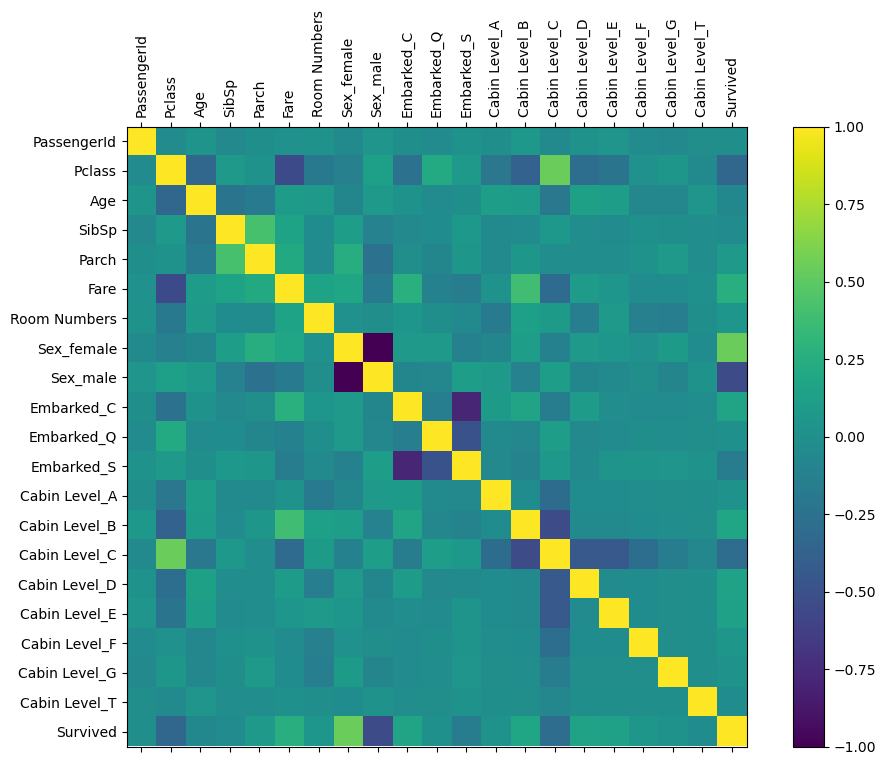

In [43]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from hashlib import md5

def hash(input: str) -> int:
    return int(md5(input.encode('utf-8')).hexdigest(), 16)

embark_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
cabin_level_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
sex_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
simpleimputer = SimpleImputer(strategy="median").set_output(transform="pandas")
standardscaler = StandardScaler().set_output(transform="pandas")

train_X, train_y = train_dataset.drop('Survived', axis=1), train_dataset['Survived']

def preprocess_dataset(train_dataset: pd.DataFrame, fit=True) -> pd.DataFrame:
    cabin_data = train_dataset['Cabin'].str.extract(r'([A-Za-z])(\d*)', expand=True)
    room_numbers = pd.to_numeric(cabin_data[1]).to_frame(name="Room Numbers")

    def getTransformerFn(encoder):
        if fit:
            return encoder.fit_transform
        return encoder.transform
    
    filled_class_level = cabin_data[0].fillna(cabin_data[0].mode().iloc[0]) # fill in with mode class level
    cabin_levels = getTransformerFn(cabin_level_encoder)(filled_class_level.to_frame(name="Cabin Level"))
    
    filled_embarked = train_dataset["Embarked"].fillna(train_dataset["Embarked"].mode().iloc[0]) # fill in with mode embark location
    embark_data = getTransformerFn(embark_encoder)(filled_embarked.to_frame())

    filled_sex = train_dataset["Sex"].fillna(train_dataset["Sex"].mode().iloc[0]) # fill in with mode sex
    sex_data = getTransformerFn(sex_encoder)(filled_sex.to_frame(name="Sex"))
    
    numeric_data = train_dataset.select_dtypes(include=[np.number])
    frame = pd.concat([numeric_data, room_numbers, sex_data, embark_data, cabin_levels], axis=1)
    imputed = getTransformerFn(simpleimputer)(frame)
    scaled = getTransformerFn(standardscaler)(imputed)
    return scaled

preprocessed = preprocess_dataset(train_X)

# Compute the correlation matrix
correlation_matrix = pd.concat([preprocessed, train_y], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()
# seaborn provides an easier to use visualisation
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [44]:
def obtain_correlated(key: str):
  return correlation_matrix[key].sort_values(key=lambda v: -abs(v))[1:]

correlated_with_survival = obtain_correlated("Survived")
print(correlated_with_survival)

Sex_male        -0.543351
Sex_female       0.543351
Pclass          -0.338481
Cabin Level_C   -0.283491
Fare             0.257307
Cabin Level_B    0.175095
Embarked_C       0.168240
Cabin Level_D    0.150716
Embarked_S      -0.149683
Cabin Level_E    0.145321
Parch            0.081629
Age             -0.064910
Cabin Level_F    0.057935
Room Numbers     0.050632
SibSp           -0.035322
Cabin Level_T   -0.026456
Cabin Level_A    0.022287
Cabin Level_G    0.016040
PassengerId     -0.005007
Embarked_Q       0.003650
Name: Survived, dtype: float64


It appears that Sex is most strongly correlated with survival, along with the passenger class - presumably the lower numeric passenger classes were the wealthier folk and so it follows that they had a higher chance of survival.
The fare and some of the cabin levels appear to also have correlation, which do also make sense logically (certain cabins would have had easier access to boats, the fare that was paid may have led to priority for the higher fare passengers - and so may be encapsulated in the Pclass attribute).

The remainder of the attributes are weakly correlated and thus are unlikely to hold predictive sway over the survivability of the passengers.

I will be using an extract from [this](https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/11-correlation-and-regression).
> If we wish to label the strength of the association, for absolute values of r, 0-0.19 is regarded as very weak, 0.2-0.39 as weak, 0.40-0.59 as moderate, 0.6-0.79 as strong and 0.8-1 as very strong correlation, but these are rather arbitrary limits, and the context of the results should be considered.

So Sex can be coined a moderate association, Pclass, Fare and being in cabin level C having a weak association, and the remainder being very weakly associated with surviving, if associated at all - which logically makes sense.

In [45]:
relevant_data = preprocessed[["Sex_male", "Sex_female", "Pclass", "Cabin Level_C", "Fare"]]

def transform_input_data(training_X):
    return preprocess_dataset(training_X)[["Sex_male", "Sex_female", "Pclass", "Cabin Level_C", "Fare"]]

Since this is a classification task (we decide if a person survived or did not), I'll use the SGDClassifier which uses a linear SVM

In [53]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(relevant_data, train_y)

predictions = sgd_classifier.predict(transform_input_data(test_X))

In [54]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predictions, test_y)

0.2825112107623318

I think that error looks pretty alright, I'll try submitting it, I'll stop with this for now (until I've gone through more of the Hands on ML book).

In [66]:
predictions = sgd_classifier.predict(transform_input_data(kaggle_test_dataset))
output_data = pd.concat([kaggle_test_dataset['PassengerId'], pd.Series(predictions, name="Survived")], axis=1).reset_index(drop=True)
output_data.to_csv(Path("output.csv"), index=False)